# Merging datasets

## Global imports and variables

In [1]:
# Import for interactive notebook (see:
# https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)
from __future__ import division, print_function
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
# In a notebook environment, display the plots inline
%matplotlib inline

# Set some parameters to apply to all plots. These can be overridden
# in each plot if desired
import matplotlib
# Plot size to 14" x 7"

matplotlib.rcParams['font.serif'] = ['CMU Serif Roman']

matplotlib.rc('figure', figsize = (20, 10))
# Font size to 14
matplotlib.rc('font', size = 40)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = False, right = False)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

# Import to list files in directories
import glob

# Import for regular expressions
import re

# Imports for path operations
import os
import os.path

# For date operations
from datetime import datetime

import pandas as pd
pd.set_option('max_colwidth', -1)

import numpy as np
import configparser


In [2]:
RESULTS_DIR = "/Users/gomerudo/workspace/thesis_results"

def rettext(text):
    return text

form_item_layout = Layout(
    width="50%"
)

## Selecting the desired results

In [3]:
import os.path
results_sorted = sorted(glob.glob("{dir}/*".format(dir=RESULTS_DIR)))
dict_widgets = {}
list_widgets = []
for result in results_sorted:
    hbox = widgets.Box()
    dict_widgets[result] = widgets.Checkbox(
        value=False,
        description=os.path.basename(result),
        disabled=False
    )
    list_widgets.append(dict_widgets[result])

half = len(results_sorted)//2

left_box = widgets.VBox(list_widgets[:half])
right_box = widgets.VBox(list_widgets[half:])
display(widgets.HBox([left_box, right_box]))

## Visualize the average through episodes

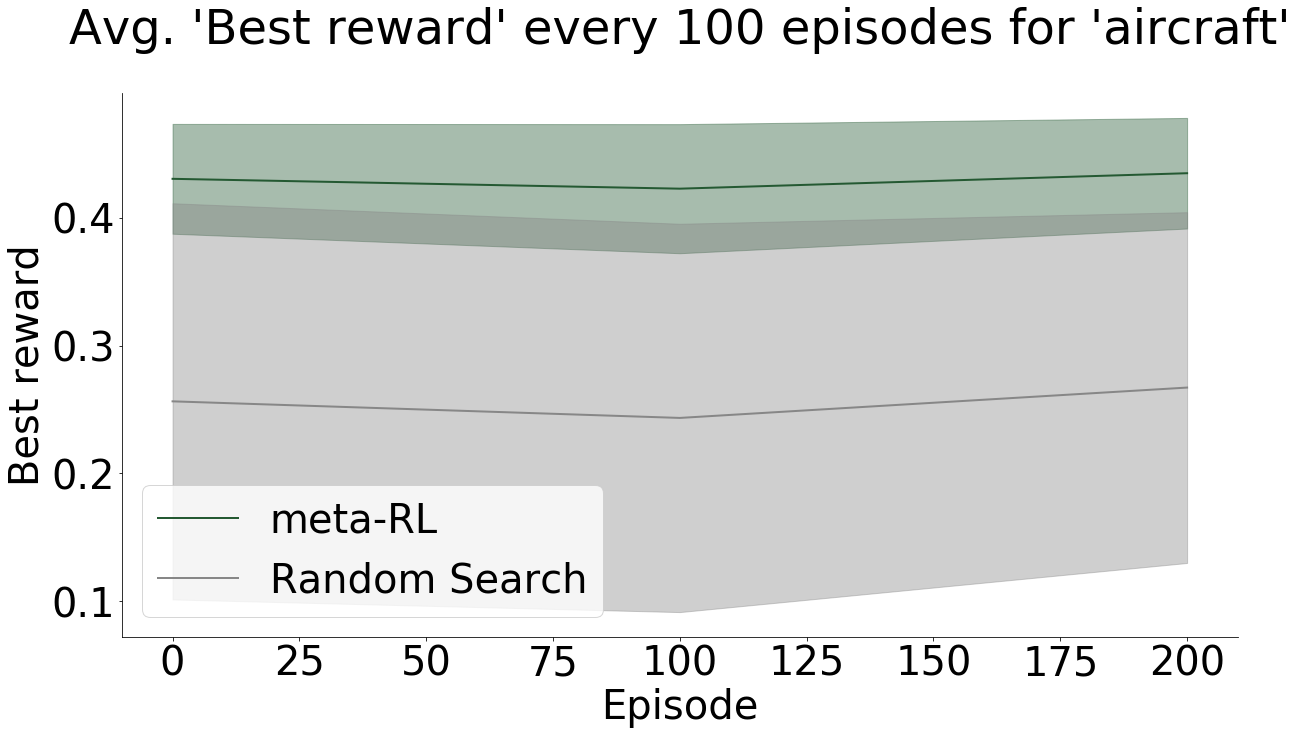

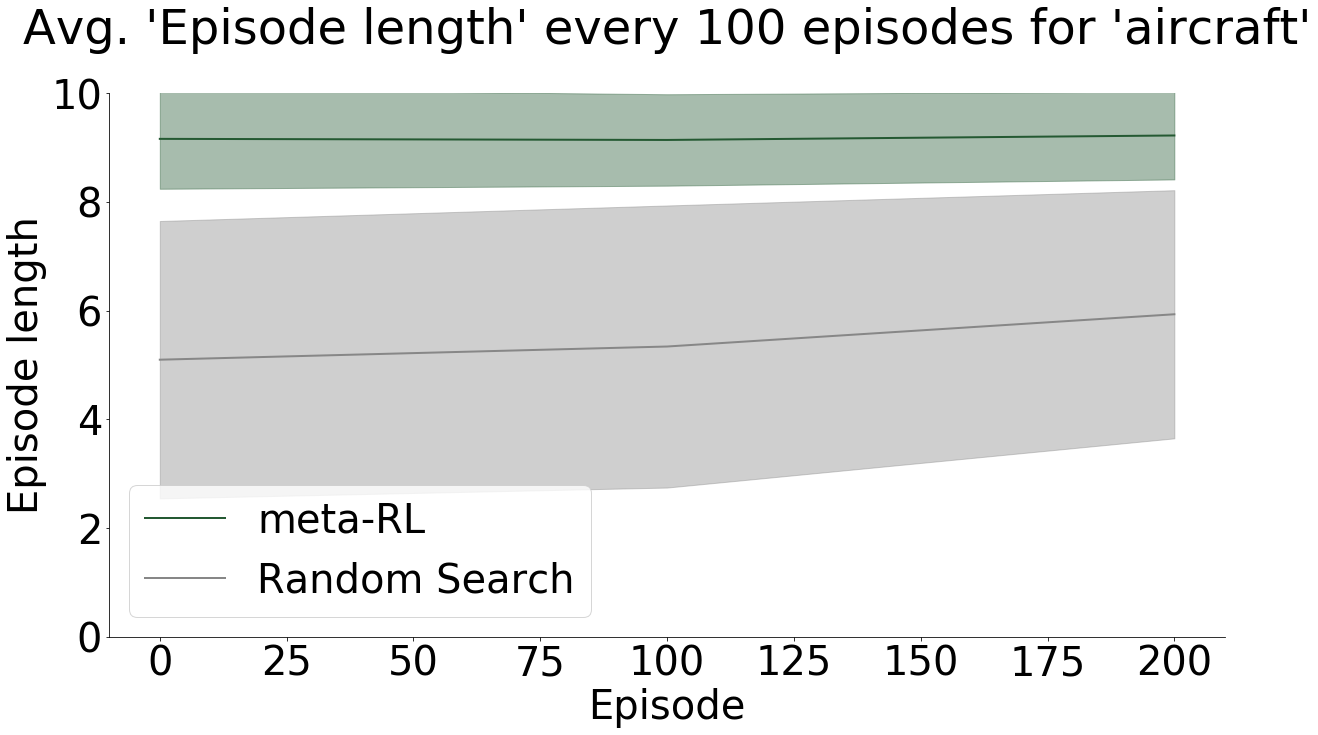

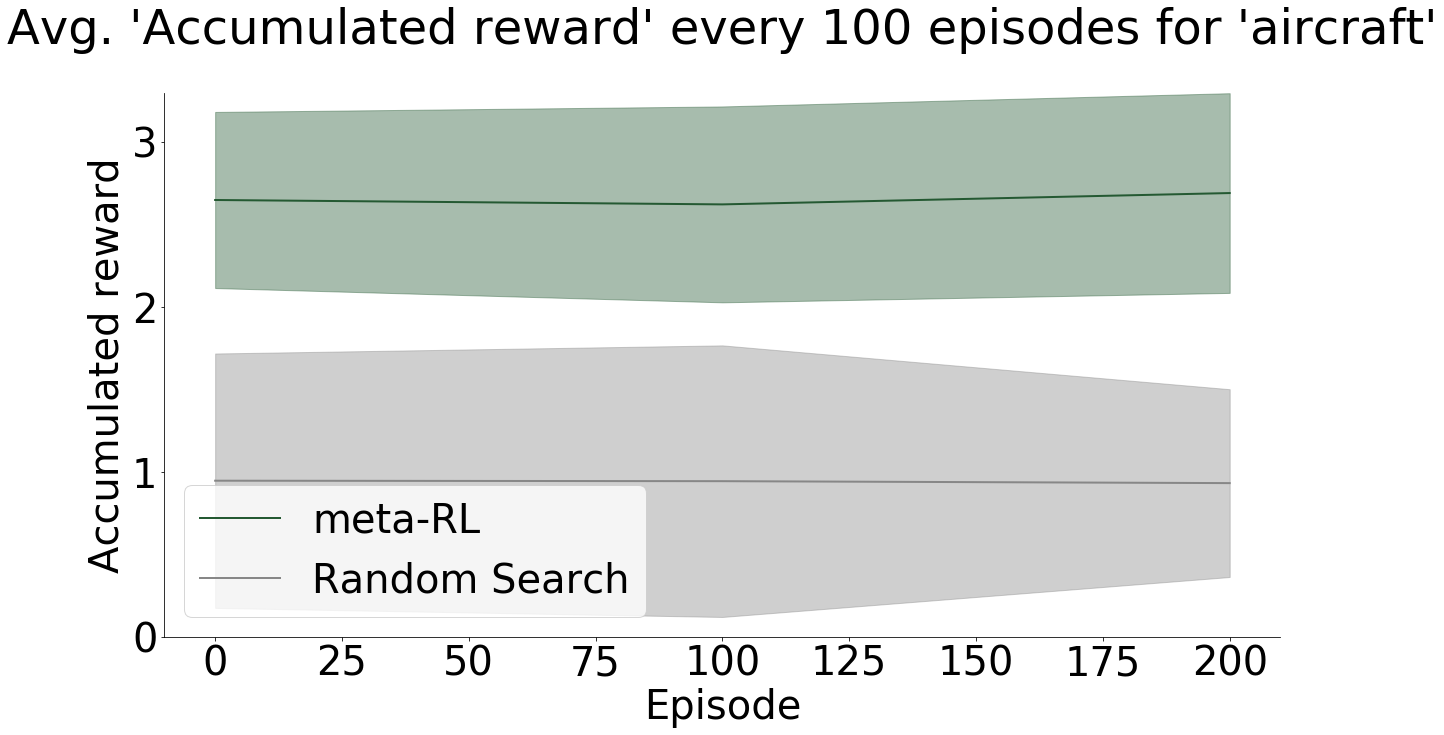

In [9]:
matplotlib.rcParams['font.serif'] = ['CMU Serif Roman']

matplotlib.rc('figure', figsize = (20, 10))
# Font size to 14
matplotlib.rc('font', size = 40)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = False, right = False)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

# Get the selected cells
selected_dirs = []

for key, widget in dict_widgets.items():
    if widget.value:
        selected_dirs.append(key)

cdir = selected_dirs[0]
src_dir = "{dir}".format(dir=cdir)

episodes_stats_csv = "{src}/episodes_stats.csv".format(src=src_dir)
epstats_df = pd.read_csv(episodes_stats_csv)
epstats_df.head()

max_eplength = epstats_df['ep_length'].max() + 1
max_accreward = epstats_df['acc_reward'].max() + 1

limits = [ None, 10, 'max']
# print(limits)
mean_n = 100
for dataset in ['omniglot', 'vgg_flower', 'dtd']:
# for dataset in ['aircraft']:
    meta_df = epstats_df[epstats_df['dataset'] == dataset]
    random_df = epstats_df[epstats_df['dataset'] == 'random-{d}'.format(d=dataset)]
    dqn_df = epstats_df[epstats_df['dataset'] == 'dqn-{d}'.format(d=dataset)]

    for metric, name_metric, limit in zip(['best_reward', 'ep_length', 'acc_reward'], ['Best reward', 'Episode length', 'Accumulated reward'], limits):
        # Compute the means and std of meta results
        means_meta = meta_df[metric].groupby(meta_df.index // mean_n).mean()
        std_meta = meta_df[metric].groupby(meta_df.index // mean_n).std()
        x_axis_meta = np.array(range(len(means_meta)))*mean_n
        
        # Compute the means and std of the dqn results 
        means_dqn = dqn_df[metric].groupby(dqn_df.index // mean_n).mean()
        std_dqn = dqn_df[metric].groupby(dqn_df.index // mean_n).std()
        x_axis_dqn = np.array(range(len(means_dqn))) *mean_n
        
        # Compute the means and std of the random results
        means_random = random_df[metric].groupby(random_df.index // mean_n).mean()
        std_random = random_df[metric].groupby(random_df.index // mean_n).std()
        x_axis_random = np.array(range(len(means_random))) *mean_n
    
        # Create the plot object
        fig, ax = plt.subplots()
#         if limit is not None:
#             ax.set_ylim(limit)
        if limit == 'max':
            ymax = max(means_meta.max(), means_dqn.max()) + max(std_meta.max(), std_dqn.max())
            ax.set_ylim([0, ymax])
        if isinstance(limit, int):
            ax.set_ylim([0, limit])
        
        # 245932 eval
        # 539caf train
        ax.plot(x_axis_meta, means_meta, lw = 2, color = '#539caf', alpha = 1, label="meta-RL".format(dataset=dataset))
        ax.fill_between(x_axis_meta, means_meta - std_meta, means_meta + std_meta, color = '#539caf', alpha = 0.4)

        ax.plot(x_axis_dqn, means_dqn, lw = 2, color = '#6e1414', alpha = 1, label="DQN".format(dataset=dataset))
        ax.fill_between(x_axis_dqn, means_dqn - std_dqn, means_dqn + std_dqn, color = '#6e1414', alpha = 0.4)

        # 878787
        ax.plot(x_axis_random, means_random, lw = 2, color = '#878787', alpha = 1, label="Random Search".format(dataset=dataset))
        ax.fill_between(x_axis_random, means_random - std_random, means_random + std_random, color = '#878787', alpha = 0.4)

        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.sans-serif'] = 'CMU Serif Roman'
        #         hfont = {'fontname':'Helvetica'}

        # Label the axes and provide a title
        ax.set_title(
            "Avg. '{metric}' every {n} episodes for '{dataset}'".format(
                metric=name_metric, n=mean_n, dataset=dataset
            ),
            y=1.08
        )
        ax.set_xlabel("Episode")
        ax.set_ylabel(name_metric)

        ax.legend(loc = 'best')
        
        import os
        save_dir = '{root}/figures'.format(root=src_dir)
        if not os.path.exists(save_dir):
            os.mkdir(save_dir);
        fig.savefig(
            '{sdir}/average-{m}-{d}.png'.format(sdir=save_dir, m=metric, d=dataset)
        )
    

## Visualize the exploration of the agent

[    0     5  3005  6005  9005 12005 15005 18005 21005 24005]


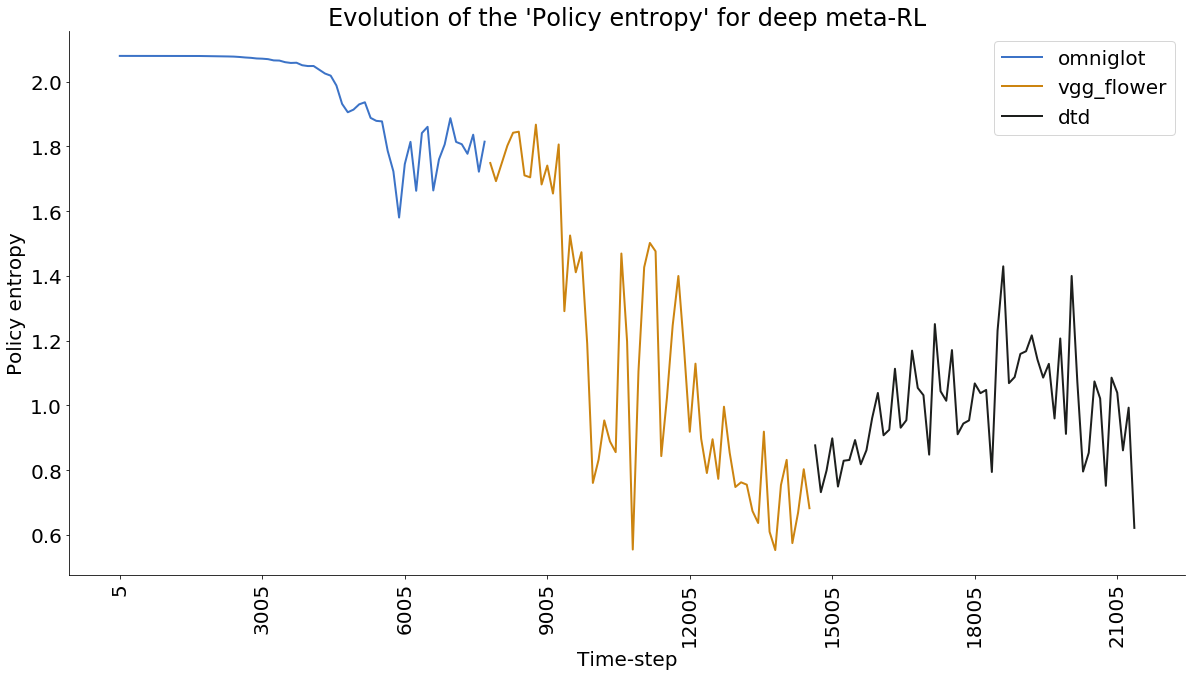

In [47]:
matplotlib.rcParams['font.serif'] = ['CMU Serif Roman']

matplotlib.rc('figure', figsize = (20, 10))
# Font size to 14
matplotlib.rc('font', size = 20)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = False, right = False)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')



# Get the selected cells
selected_dirs = []

for key, widget in dict_widgets.items():
    if widget.value:
        selected_dirs.append(key)

cdir = selected_dirs[0]
src_dir = "{dir}".format(dir=cdir)

progress_csv = "{src}/progress.csv".format(src=src_dir)
progress_df = pd.read_csv(progress_csv)
progress_df.head()

max_acc = 0
res = {}
# all_values = None
for dataset in ['omniglot', 'vgg_flower', 'dtd']:
    dataset_progress_df = progress_df[progress_df['dataset'] == dataset]
    
    for metric, name_metric in zip(['policy_entropy'], ['Policy entropy']):
        metric_df = dataset_progress_df[metric]
        
#         if all_values is None:
#             all_values = metric_df
#         else:
#             all_values = np.append(all_values, metric_df)
        
        # Keep track of the 
        jump = metric_df.shape[0]
        max_acc += jump
#         print(max_acc)
        res[dataset] = np.append(np.full([max_acc - jump], np.nan), metric_df)
        

# Fix the lengths
# for key in res.keys():
n_target = res['dtd'].shape[0]
# print(n_target)

res['omniglot'] = np.append(res['omniglot'], np.full([n_target - res['omniglot'].shape[0]], np.nan))
res['vgg_flower'] = np.append(res['vgg_flower'], np.full([n_target - res['vgg_flower'].shape[0]], np.nan))
# dataset_progress_df
    
# Create the plot object
fig, ax = plt.subplots()

# ax.plot(list(range(len(all_values))), all_values, lw = 2, color = '#539caf', alpha = 1, label="omniglot".format(dataset=dataset))
ax.plot(list(range(n_target)), res['omniglot'], lw = 2, color = '#3c73c7', alpha = 1, label="omniglot".format(dataset=dataset))
ax.plot(list(range(n_target)), res['vgg_flower'], lw = 2, color = '#cc8410', alpha = 1, label="vgg_flower".format(dataset=dataset))
ax.plot(list(range(n_target)), res['dtd'], lw = 2, color = '#1d1f1d', alpha = 1, label="dtd".format(dataset=dataset))

ax.set_title("Evolution of the 'Policy entropy' for deep meta-RL".format(metric=name_metric, n=mean_n, dataset=dataset))
ax.set_xlabel("Time-step")
ax.set_ylabel(name_metric)

ticks = ax.get_xticks()*120 + 5
ticks[0] = 0
ticks = np.array(ticks, dtype=np.int)
print(ticks)
ax.set_xticklabels(ticks, rotation=90)
ax.legend(loc = 'best')

import os
save_dir = '{root}/figures'.format(root=src_dir)
if not os.path.exists(save_dir):
    os.mkdir(save_dir);
fig.savefig(
    '{sdir}/entropy.png'.format(sdir=save_dir)
)   # save the figure to file

